In [7]:
import torch
import numpy as np
from collections import deque
import gym

In [8]:
#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

In [9]:
class Actor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(3 , 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )
    
    def forward(self,X):
        return self.fc(X)

actor = Actor()
actor_delay = Actor()
actor_delay.load_state_dict(actor.state_dict())

actor(torch.randn(2, 3))

tensor([[0.0737],
        [0.1081]], grad_fn=<TanhBackward0>)

In [10]:
class Critic(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(4 , 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
        )
    
    def forward(self,X):
        return self.fc(X)

critic = Critic()
critic_delay = Critic()
critic_delay.load_state_dict(critic.state_dict())

critic(torch.randn(2,4))

tensor([[0.0095],
        [0.0370]], grad_fn=<AddmmBackward0>)

In [11]:
from IPython import display
import random


def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = actor(torch.FloatTensor(state).reshape(1, 3)).item()

        action += random.normalvariate(mu=0, sigma=0.2)

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum

data , r = play()
print(data)

[(array([ 0.957916  , -0.28704858, -0.31386268], dtype=float32), 0.1077035542175395, 0.9881672011447824, array([ 0.95049036, -0.310754  , -0.49683803], dtype=float32), False), (array([ 0.95049036, -0.310754  , -0.49683803], dtype=float32), 0.15216655316625805, 0.9844219110136287, array([ 0.9393045 , -0.34308463, -0.6842536 ], dtype=float32), False), (array([ 0.9393045 , -0.34308463, -0.6842536 ], dtype=float32), -0.1367739753231871, 0.978808201018775, array([ 0.92132217, -0.38880008, -0.98259926], dtype=float32), False), (array([ 0.92132217, -0.38880008, -0.98259926], dtype=float32), 0.1694836199380617, 0.9679839293215842, array([ 0.89583194, -0.444393  , -1.2233542 ], dtype=float32), False), (array([ 0.89583194, -0.444393  , -1.2233542 ], dtype=float32), -0.23065423505933558, 0.9547588180280098, array([ 0.8567876 , -0.51566947, -1.6258453 ], dtype=float32), False), (array([ 0.8567876 , -0.51566947, -1.6258453 ], dtype=float32), -0.01595390603587299, 0.9302658200538949, array([ 0.80050

In [12]:
class Pool:
    def __init__(self):
        self.max_size = 20000
        self.pool = deque(maxlen=self.max_size)  # 使用deque, 自动移除多余数据

    def __len__(self):
        return len(self.pool)
    
    def __getitem__(self, i):
        return self.pool[i]

    def update(self):
        # 获取新episode
        episode, treward = play()
        
        # 使用deque时，无需手动删除旧数据，超过最大长度时会自动移除
        self.pool.extend(episode)

    def sample(self, k=64):
        # 从池中随机采样 k 个样本
        data = random.sample(self.pool, k)

        # 使用numpy进行批量转换，提高效率
        state = np.array([i[0] for i in data], dtype=np.float32).reshape(-1, 3)
        action = np.array([i[1] for i in data], dtype=np.float32).reshape(-1, 1)
        reward = np.array([i[2] for i in data], dtype=np.float32).reshape(-1, 1)
        next_state = np.array([i[3] for i in data], dtype=np.float32).reshape(-1, 3)
        over = np.array([i[4] for i in data], dtype=np.int64).reshape(-1, 1)

        # 将numpy数组转换为torch张量
        state = torch.from_numpy(state)
        action = torch.from_numpy(action)
        reward = torch.from_numpy(reward)
        next_state = torch.from_numpy(next_state)
        over = torch.from_numpy(over)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
s , a , r , ns , o = pool.sample()
ns.shape, len(pool), pool[0]

(torch.Size([64, 3]),
 200,
 (array([ 0.76120347, -0.64851314, -0.09405936], dtype=float32),
  0.1989139009017252,
  0.9376305085459316,
  array([ 0.74406105, -0.6681116 , -0.52077   ], dtype=float32),
  False))

In [13]:
optimizer_action = torch.optim.Adam(actor.parameters(), lr=5e-4)
optimizer_value = torch.optim.Adam(critic.parameters(), lr=5e-3)

def soft_update(_from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
        value = _to.data * 0.7 + _from.data * 0.3
        _to.data.copy_(value)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)


requires_grad(actor_delay, False)
requires_grad(critic_delay, False)

In [14]:
def train_actor(state):
    requires_grad(actor, True)
    requires_grad(critic, False)

    #首先把动作计算出来
    action = actor(state)

    #使用value网络评估动作的价值,价值是越高越好
    input = torch.cat([state, action], dim=1)
    loss = -critic(input).mean()

    optimizer_value.zero_grad()
    loss.backward()
    optimizer_action.step()

    return loss.item()


train_actor(s)

0.03621241822838783

In [15]:
def train_critic(state, action, reward, next_state, over):
    requires_grad(actor, False)
    requires_grad(critic, True)

    #计算value
    input = torch.cat([state, action], dim=1)
    value = critic(input)

    #计算target
    with torch.no_grad():
        next_action = actor_delay(next_state)
        input = torch.cat([next_state, next_action], dim=1)
        target = critic_delay(input)
    target = target * 0.99 * (1 - over) + reward

    #计算td loss,更新参数
    loss = torch.nn.functional.mse_loss(value, target)

    optimizer_value.zero_grad()
    loss.backward()
    optimizer_value.step()

    return loss.item()


train_critic(s, a, r, ns, o)

0.25494131445884705

In [16]:
#训练
def train():
    actor.train()
    critic.train()

    #共更新N轮数据
    for epoch in range(200):
        pool.update()

        #每次更新数据后,训练N次
        for _ in range(200):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample()

            #训练模型
            a_loss = train_actor(state)
            c_loss = train_critic(state, action, reward, next_state, over)
            #a_loss_num = sum(a_loss)/len(a_loss)
            #c_loss_num = sum(c_loss)/len(c_loss)

        soft_update(actor, actor_delay)
        soft_update(critic, critic_delay)

        if epoch % 20 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(f'epoch:{epoch}, pool_size:{len(pool)}, reward:{test_result}, a_loss:{a_loss}, c_loss:{c_loss}')


train()

epoch:0, pool_size:400, reward:-14.89689507927584, a_loss:-0.2502514719963074, c_loss:0.00038619429687969387
epoch:20, pool_size:4400, reward:78.67734338215135, a_loss:-1.26649010181427, c_loss:0.09833516925573349
epoch:40, pool_size:8400, reward:95.6872965676391, a_loss:-6.3661651611328125, c_loss:0.01605735346674919
epoch:60, pool_size:12400, reward:181.99351343472847, a_loss:-9.54293155670166, c_loss:3.486393451690674
epoch:80, pool_size:16400, reward:180.53671610286884, a_loss:-14.139174461364746, c_loss:6.10191011428833
epoch:100, pool_size:20000, reward:180.88435413767098, a_loss:-18.536453247070312, c_loss:0.12375754863023758
epoch:120, pool_size:20000, reward:176.27092555844067, a_loss:-25.34331703186035, c_loss:0.30073875188827515
epoch:140, pool_size:20000, reward:180.92089294856822, a_loss:-30.29701805114746, c_loss:0.04592553526163101
epoch:160, pool_size:20000, reward:182.91332320434958, a_loss:-33.790184020996094, c_loss:0.17782889306545258
epoch:180, pool_size:20000, rew

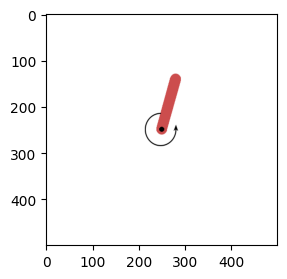

168.95083244136347

In [17]:
play(True)[-1]